# Projekt: klasyfikacja gatunku utworu muzycznego na podstawie nagrania audio

## Dataset

GTZAN - zbiór tysiąca 30 sekundowych nagrań audio utworów muzycznych z 10 gatunków.

## Co ma powiedzieć analiza danych
Jakie wspólne cechy mają utwory muzyczne z tego samego gatunku?

## Plan
- EDA
- Feature engineering
- Porównanie poznanych na wykładzie modeli do klasyfikacji
- Zastosowanie metod machine learning'u, które pojawiły się na ćwiczeniach (np. wykrywanie outlier'ów, feature selection)
- Różne pomysły, które przyjdą nam do głowy (np. sprawdzanie jak modele radzą sobie z zaszumioną muzyką, albo czy dane z 3 sekundowego utworu wystarczą do klasyfikacji)
- klasteryzacja w gatunkach, żeby zobaczyć jakie są typowe osobniki
- knn na chroma
- gdzie model się myli

## Co trza najpierw zrobić
- pipeline preprocessingu danych
- pipeline treningu
- pipeline oceny


In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv("Data/features_30_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [96]:
ipd.Audio('Data/genres_original/pop/pop.00012.wav')

In [5]:
genres = df['label'].unique()

In [60]:
files_by_genre = {g: list(df[df['label'] == g]['filename']) for g in genres}

In [6]:
audio_paths = [f'Data/genres_original/{g}/{g}.00000.wav' for g in genres]
audio_paths

['Data/genres_original/blues/blues.00000.wav',
 'Data/genres_original/classical/classical.00000.wav',
 'Data/genres_original/country/country.00000.wav',
 'Data/genres_original/disco/disco.00000.wav',
 'Data/genres_original/hiphop/hiphop.00000.wav',
 'Data/genres_original/jazz/jazz.00000.wav',
 'Data/genres_original/metal/metal.00000.wav',
 'Data/genres_original/pop/pop.00000.wav',
 'Data/genres_original/reggae/reggae.00000.wav',
 'Data/genres_original/rock/rock.00000.wav']

In [79]:
def full_filename_from_path(path):
    g = path.split('.')[0]
    return f'Data/genres_original/{g}/{path}'

# Tempo

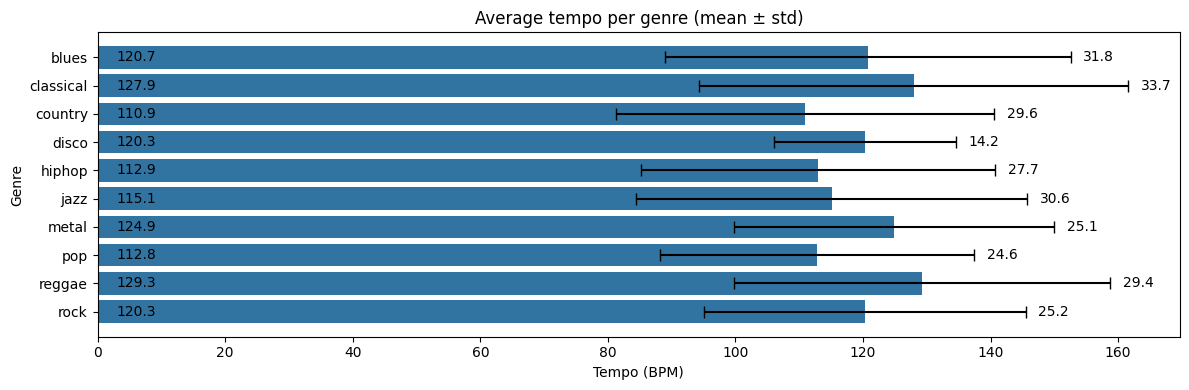

In [101]:
tempo_data = df.groupby("label")["tempo"].agg(mean="mean", std="std").reset_index()

plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=tempo_data,
    x="mean",
    y="label",
    errorbar=None,
)

ax.errorbar(
    x=tempo_data["mean"],
    y=range(len(tempo_data)),
    xerr=tempo_data["std"],
    fmt="none",
    c="black",
    capsize=4
)

ax.set_xlabel("Tempo (BPM)")
ax.set_ylabel("Genre")
ax.set_title("Average tempo per genre (mean ± std)")

# labels for mean
for i, row in enumerate(tempo_data['mean']):
    ax.text(
        3,
        i,
        f"{row:.1f}",
        va="center"
    )

# labels for std
for i, (mean_val, std_val) in enumerate(zip(tempo_data['mean'], tempo_data['std'])):
    ax.text(
        mean_val + std_val + 2,
        i,
        f"{std_val:.1f}",
        va="center"
    )

plt.tight_layout()
plt.show()


# Mel-frequency cepstral coefficients (MFCCs)

Poniżej przedstawiam wizualizację [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), czyli współczynników, które składają się na reprezentację pewnego spektrum dźwięku (TODO: zrobić opis, który faktycznie coś tłumaczy)


- Współczynnik ma dodatnie wartości -> większość energii spektralnej jest w regionach o niskiej częstotliwości
- Współczynnik ma ujemne wartości -> większość energii jest jest w wysokich częstotliwościach

In [7]:
def visualize_mfcc(audio_path, ax):
    y, sr = librosa.load(audio_path, sr=None)
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    img = librosa.display.specshow(
        mfccs, 
        sr=sr, 
        x_axis='time', 
        ax=ax,
    )
    
    title = audio_path.split('/')[-1]
    ax.set_title(f'{title}', pad=10)
    ax.set_ylabel("MFCC\nindex", fontsize=9)

    return img

Text(0, 0.5, 'MFCC value')

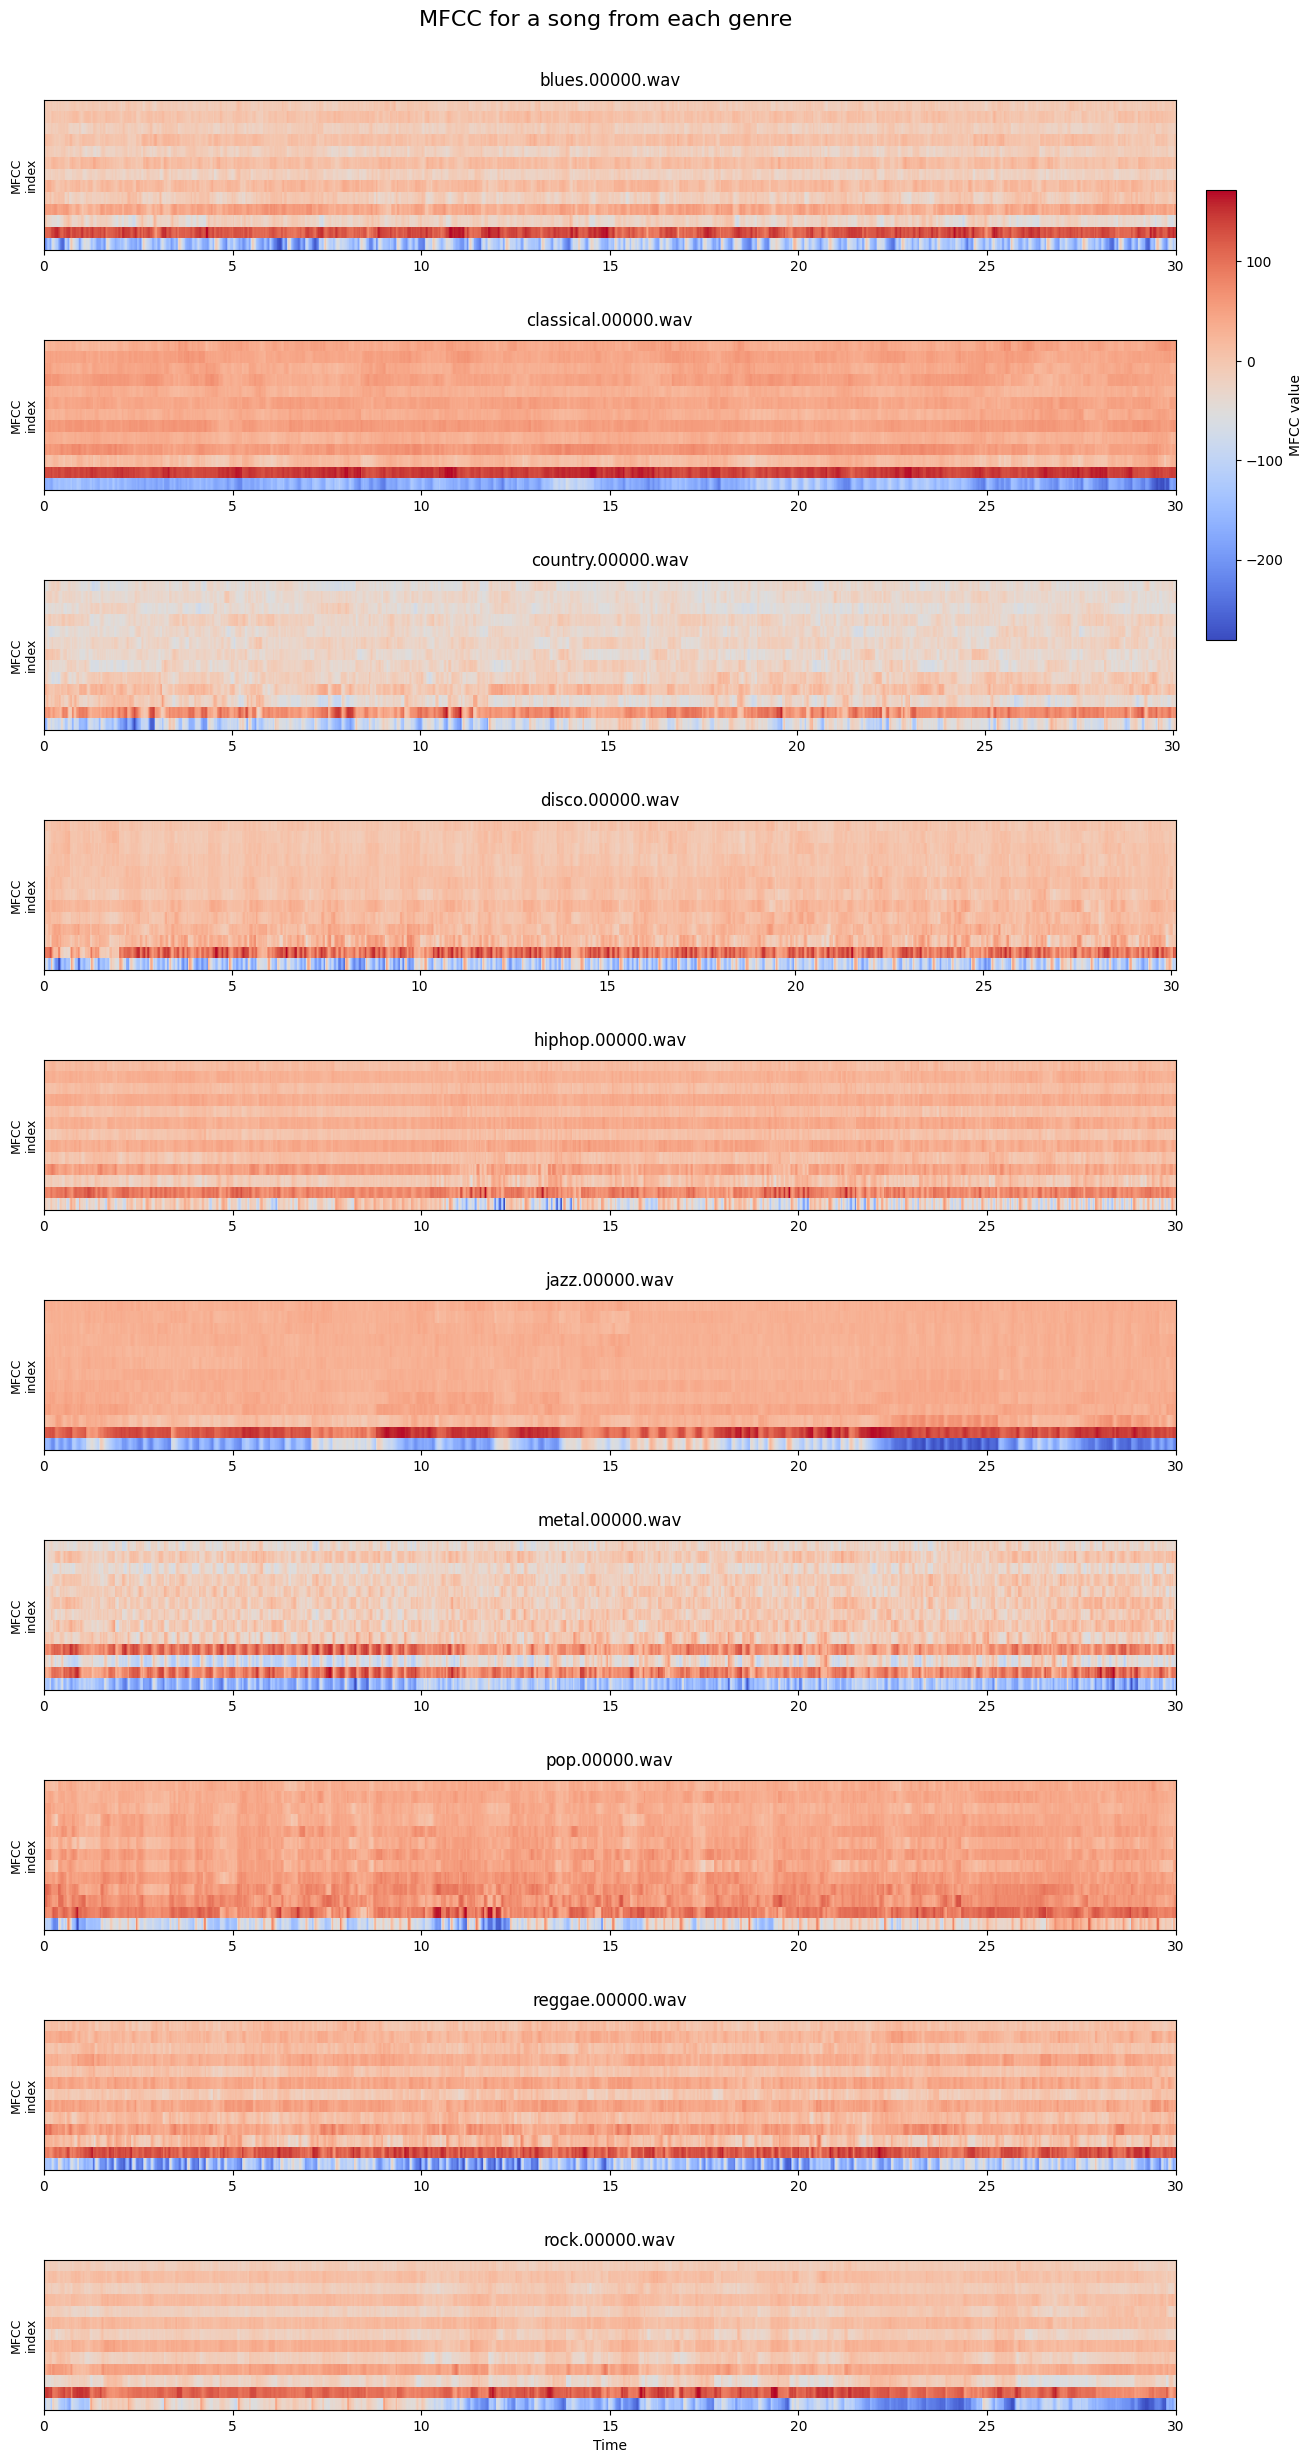

In [52]:
fg, axs = plt.subplots(len(audio_paths), 1, figsize=(15, 30))

for i, ap in enumerate(audio_paths):
    img = visualize_mfcc(ap, axs[i])

fg.subplots_adjust(hspace=0.6, right=0.88)
fg.suptitle("MFCC for a song from each genre", fontsize=16, y=0.91)

for ax in axs[:-1]:
    ax.set_xlabel("")

cbar_ax = fg.add_axes([0.9, 0.70, 0.02, 0.15])
fg.colorbar(img, cax=cbar_ax)
cbar_ax.set_ylabel("MFCC value", fontsize=10)

In [ ]:
def get_mffc(path):
    y, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Chroma

In [91]:
def visualize_chroma_over_time(audio_path, ax):
    title = audio_path.split('/')[-1]
    y, sr = librosa.load(audio_path)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax = ax)
    # plt.colorbar()
    ax.set_title(f'Chroma over time for {title}', pad=10)
    # ax.set_ylabel("MFCC\nindex", fontsize=9)
    return img

Text(0, 0.5, 'Chroma value')

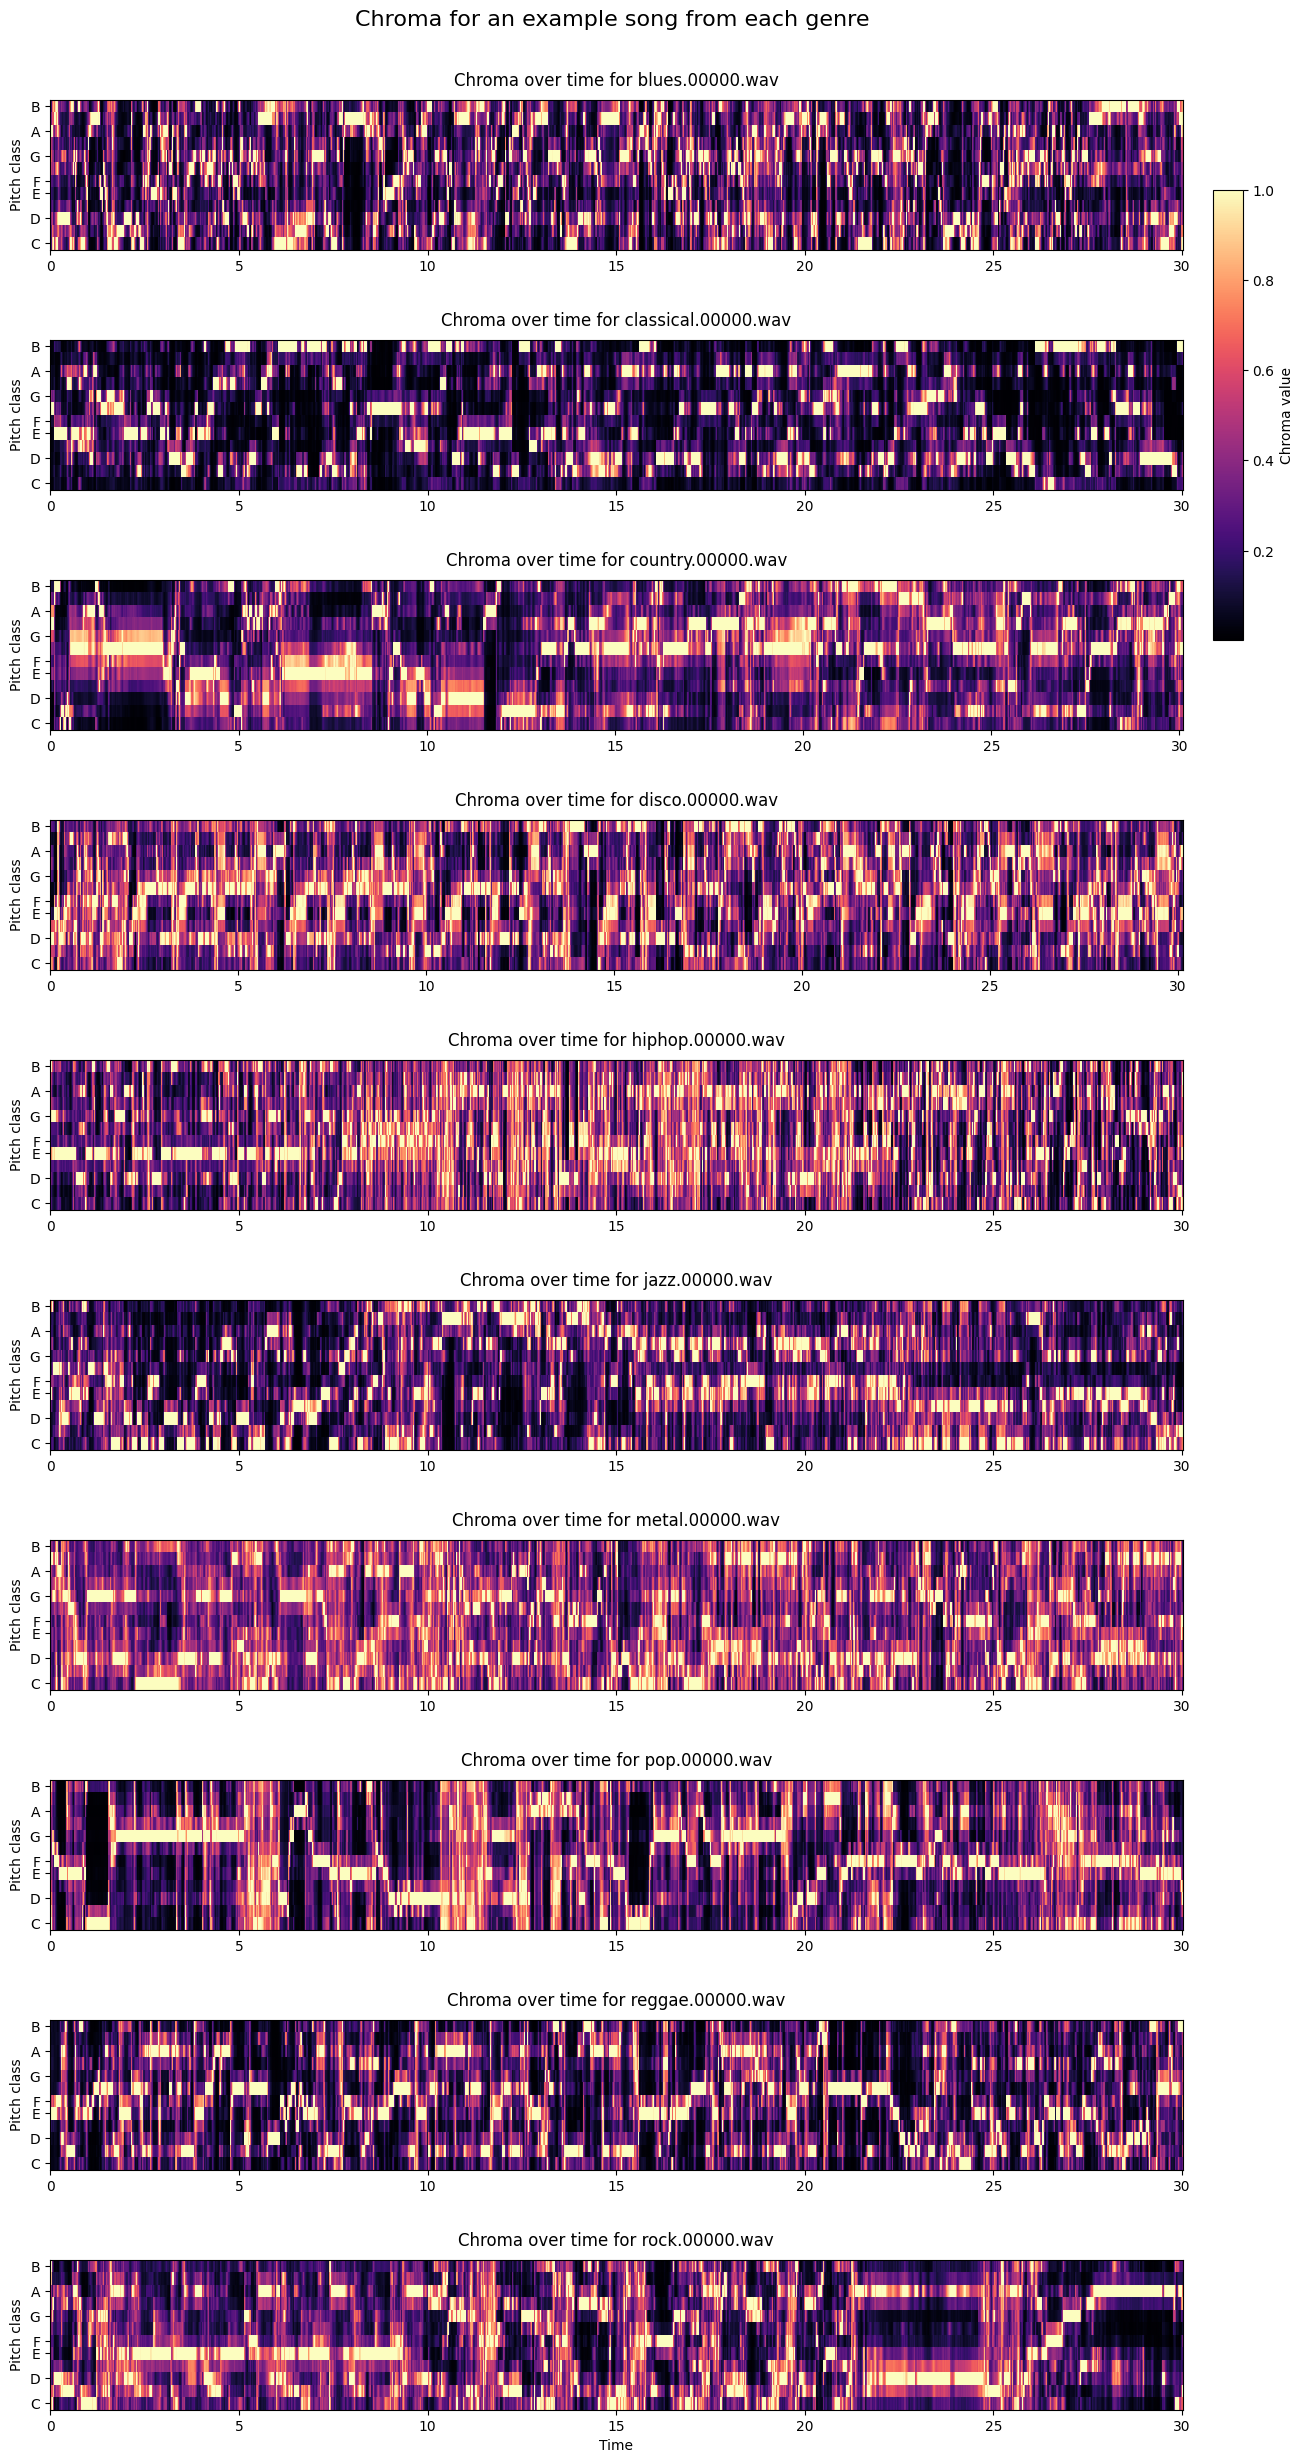

In [102]:
fg, axs = plt.subplots(len(audio_paths), 1, figsize=(15, 30))

for i, ap in enumerate(audio_paths):
    img = visualize_chroma_over_time(ap, axs[i])

fg.subplots_adjust(hspace=0.6, right=0.88)
fg.suptitle("Chroma for an example song from each genre", fontsize=16, y=0.91)

for ax in axs[:-1]:
    ax.set_xlabel("")

cbar_ax = fg.add_axes([0.9, 0.70, 0.02, 0.15])
fg.colorbar(img, cax=cbar_ax)
cbar_ax.set_ylabel("Chroma value", fontsize=10)

In [85]:
def get_chroma(audio_path):
    try:
        path = full_filename_from_path(audio_path)
        y, sr = librosa.load(path)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        return chroma
    except Exception as e:
        print(f'failed for file: {audio_path}')
        return None

jazz_chromas = [get_chroma(path) for path in files_by_genre['jazz']]
jazz_chromas = [c for c in jazz_chromas if c is not None]

/tmp/ipykernel_22494/1411333664.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path)
/home/adziw/Uni/venv_ai/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


failed for file: jazz.00054.wav


# Baseline model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

In [10]:
X, y = df.drop(['filename', 'length', 'label'], axis=1), df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
model = svm.SVC()
model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [12]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Baseline model accuracy = {acc:0.2f}')

Baseline model accuracy = 0.21
